In [1]:
# Enable further imports

import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import matplotlib.pyplot as plt
import torch

from torch.nn import ModuleList, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split

from sklearn.metrics import classification_report

from tqdm.notebook import tqdm

from data import BinaryColoredMNIST

from models import MLPEncoder, ConvEncoder, Classifier, Adversary

from train import Trainer

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

mps


### Data Modification

In [4]:
data_dir = os.path.join(project_root, "data/mnist_data")
train_set = BinaryColoredMNIST(root=data_dir, p_even_red=0.8, p_odd_red=0.4, prob_a=0.5)

In [5]:
train_set, val_set = random_split(train_set, [0.8, 0.2])

In [6]:
# data = train_set[:144]

# plt.figure(figsize=(8, 8))

# for i, (img, a, label) in enumerate(data):
#     plt.subplot(12, 12, i + 1)
#     plt.imshow(img.permute(1, 2, 0).numpy())
#     plt.title(str(label.item()), fontsize=8)
#     plt.axis("off")

# plt.tight_layout()
# plt.show()

In [7]:
# Setup for DP
C = 2
K = 2
latent_dim = 10

batch_size = 256
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

encoder = MLPEncoder(latent_dim)
classifier = Classifier(latent_dim)
adversary = Adversary(latent_dim)

trainer = Trainer(train_loader, val_loader, encoder, classifier, adversary, C, K, device)

In [8]:
gamma = 0.001

learning_rate = 1e-2

criterion_class = CrossEntropyLoss()
optimizer_enc_class = Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=learning_rate)
optimizer_adv = Adam(adversary.parameters(), lr=learning_rate)

losses_enc, losses_adv = trainer.train(criterion_class, optimizer_enc_class, optimizer_adv, gamma, verbose=True)

  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 1 (encoder+classifier loss: 0.3103, adversary loss: -0.6778)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 2 (encoder+classifier loss: 0.1480, adversary loss: -0.7373)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 3 (encoder+classifier loss: 0.1086, adversary loss: -0.4333)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 4 (encoder+classifier loss: 0.0982, adversary loss: -0.4413)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 5 (encoder+classifier loss: 0.0868, adversary loss: -0.4382)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 6 (encoder+classifier loss: 0.0799, adversary loss: -0.4389)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 7 (encoder+classifier loss: 0.0728, adversary loss: -0.4418)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 8 (encoder+classifier loss: 0.0709, adversary loss: -0.4384)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 9 (encoder+classifier loss: 0.0609, adversary loss: -0.4394)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 10 (encoder+classifier loss: 0.0556, adversary loss: -0.4408)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 11 (encoder+classifier loss: 0.0530, adversary loss: -0.4385)


  0%|          | 0/188 [00:00<?, ?batch/s]

Epoch 12 (encoder+classifier loss: 0.0523, adversary loss: -0.4409)


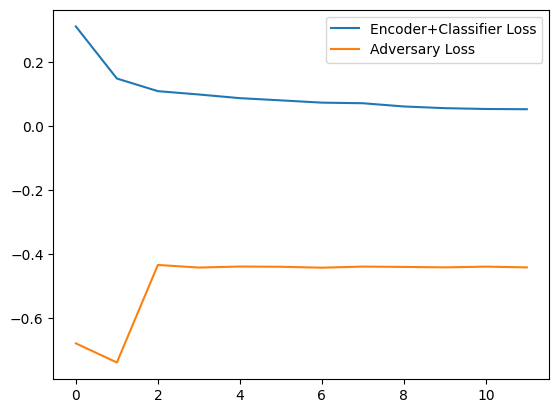

In [9]:
plt.plot(losses_enc, label="Encoder+Classifier Loss")
plt.plot(losses_adv, label="Adversary Loss")

plt.legend()
plt.show()

In [10]:
test_set = BinaryColoredMNIST(root=data_dir, p_even_red=0.8, p_odd_red=0.7, prob_a=0.5, train=False)
x, a_true, y_true = zip(*test_set)

x = torch.stack(x, dim=0).to(device)
a_true = torch.stack(a_true, dim=0).to(device)
y_true = torch.stack(y_true, dim=0).to(device)

z = encoder(x)

a_pred = trainer.pred_adversary(z, y_true).argmax(dim=1)
y_pred = classifier(z).argmax(dim=1)

# test_loader = tqdm(
#     DataLoader(test_set, batch_size=batch_size, shuffle=True),
#     unit="batch",
#     leave=False
# )

# y_pred = []
# y_true = []
# a_pred = []
# a_true = []

# for (x, a, y) in test_loader:
#     x = x.to(device)
#     a = a.to(device)
#     y = y.to(device)

#     z = encoder(x)
    
#     y_preds = classifier(z).argmax(dim=1)
#     a_preds = trainer.pred_adversary(z, y).argmax(dim=1)
    
#     a_pred.append(a_preds.cpu())
#     y_pred.append(y_preds.cpu())
    
#     a_true.append(a.cpu())
#     y_true.append(y.cpu())

# a_pred = torch.cat(a_pred, dim=0).numpy()
# a_true = torch.cat(a_true, dim=0).numpy()

# y_pred = torch.cat(y_pred, dim=0).numpy()
# y_true = torch.cat(y_true, dim=0).numpy()

In [11]:
a_pred = a_pred.cpu().numpy()
a_true = a_true.cpu().numpy()
y_pred = y_pred.cpu().numpy()
y_true = y_true.cpu().numpy()

print("Classifier:")
print(classification_report(y_true, y_pred, zero_division=0))

print()
print()

print("Adversary:")
print(classification_report(a_true, a_pred, zero_division=0))

Classifier:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      4926
           1       0.98      0.97      0.97      5074

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



Adversary:
              precision    recall  f1-score   support

           0       0.81      0.53      0.64      7499
           1       0.31      0.63      0.41      2501

    accuracy                           0.56     10000
   macro avg       0.56      0.58      0.53     10000
weighted avg       0.69      0.56      0.59     10000

